In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [26]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale and normalize data
mms = preprocessing.MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_raw)
X_dev_scaled, X_test_scaled = mms.transform(X_dev_raw), mms.transform(X_test_raw)

ss = preprocessing.StandardScaler()
X_train_std = ss.fit_transform(X_train_raw)
X_dev_std, X_test_std = ss.transform(X_dev_raw), ss.transform(X_test_raw)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]

### Linear Regression

#### Base model

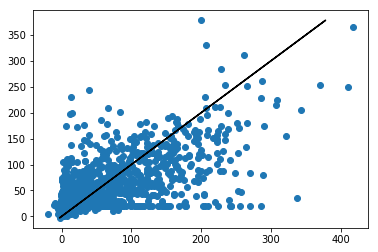

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-1,fumble-1,fanPts-1,yards_gained-1,rec_yards-1,rush_yards-1,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-3,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,incomplete_pass-3,pass_attempt-1,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-2,yards_after_catch-3,air_yards-3,air_yards-1
1,-63963482571.977,21321160856.250,10660580428.686,-1066058030.825,-11.962,-11.902,9.725,9.705,-9.575,7.765,6.992,-6.920,-6.892,6.533,5.209,4.729,4.477,3.764,-3.742,3.313,2.630,-2.427,2.299,-2.256,2.210,-1.972,-1.969,-1.961,1.781,-1.304,1.133,-1.073,-1.024,0.994,-0.676,-0.610,-0.593,-0.481,-0.473,0.469,-0.323,0.262,-0.256,0.184,-0.153,-0.106,-0.081,0.057,0.057,-0.052,-0.023,-0.018,-0.015,0.014,0.013,0.009,0.008,0.008,-0.007,0.003


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.LinearRegression()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

### Ridge Regression

#### Base model

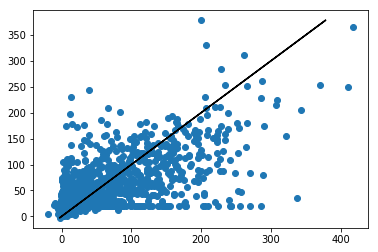

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-1,rec_yards-1,rush_yards-1,rush_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,pass_attempt-1,incomplete_pass-3,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,fumble-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,touchdown-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,fanPts-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,yards_after_catch-3,air_yards-2,air_yards-3,air_yards-1
1,8.666,8.646,-8.517,7.738,6.903,-6.831,-6.770,6.506,6.330,-6.258,-6.231,5.192,4.712,4.443,3.733,-3.710,3.281,2.613,-2.426,2.282,-2.230,2.183,-1.958,-1.945,-1.941,1.762,-1.280,1.128,-1.067,-1.013,0.991,-0.938,-0.689,-0.611,-0.592,-0.480,-0.472,0.470,-0.412,-0.322,0.263,-0.255,0.184,-0.153,-0.106,0.093,-0.081,0.057,0.057,-0.052,-0.022,-0.018,-0.015,0.014,0.012,0.009,0.008,0.008,-0.007,0.003


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Ridge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:   10.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished


Best parameters set found on development set:
{'alpha': 100000, 'normalize': False}


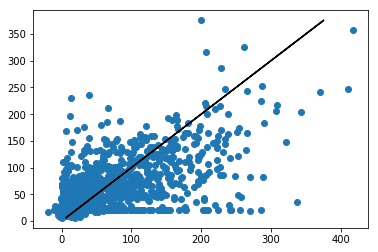

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-1,qb_dropback-2,rush_attempt-1,qb_dropback-3,fanPts-1,incomplete_pass-1,pass_attempt-1,tackled_for_loss-1,rush_attempt-3,fumble-1,fumble-2,incomplete_pass-2,qb_hit-2,incomplete_pass-3,complete_pass-2,qb_hit-1,no_huddle-1,tackled_for_loss-2,complete_pass-3,tackled_for_loss-3,yards_gained-1,shotgun-3,fanPts-2,rush_yards-1,fumble-3,pass_touchdown-3,pass_attempt-3,interception-1,no_huddle-3,rush_attempt-2,touchdown-2,shotgun-1,rush_touchdown-3,rec_yards-2,yards_gained-3,touchdown-3,yards_gained-2,interception-2,pass_attempt-2,rush_yards-3,yards_after_catch-1,fanPts-3,complete_pass-1,shotgun-2,rush_touchdown-2,yards_after_catch-2,yards_after_catch-3,no_huddle-2,touchdown-1,rec_yards-3,air_yards-3,rec_yards-1,rush_touchdown-1,pass_touchdown-2,rush_yards-2,air_yards-2,pass_touchdown-1,air_yards-1,interception-3,qb_hit-3
1,-0.288,-0.270,-0.233,-0.196,0.194,0.187,0.152,0.135,-0.130,-0.114,-0.109,-0.098,-0.092,0.085,0.081,-0.079,-0.068,0.063,-0.060,0.058,0.058,-0.057,0.056,0.052,-0.049,0.042,0.037,-0.032,0.030,-0.029,-0.027,0.026,-0.025,0.021,0.020,-0.019,0.019,0.018,-0.017,0.016,-0.015,-0.015,0.014,0.011,0.010,0.008,0.008,-0.007,-0.006,0.006,-0.006,0.005,0.005,-0.005,-0.005,0.004,0.004,0.003,0.003,0.002


In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Ridge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Ridge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Lasso Regression

#### Base model

C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


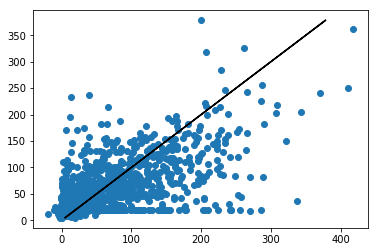

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-1,incomplete_pass-1,fumble-2,tackled_for_loss-1,rush_attempt-1,pass_attempt-1,qb_dropback-2,qb_dropback-3,fanPts-1,incomplete_pass-2,qb_hit-2,rush_attempt-3,incomplete_pass-3,qb_hit-1,complete_pass-2,yards_gained-1,no_huddle-1,fumble-1,shotgun-3,rush_yards-1,fanPts-2,shotgun-1,yards_gained-2,yards_gained-3,rec_yards-2,rec_yards-1,yards_after_catch-1,rush_yards-2,complete_pass-1,rush_yards-3,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-3,air_yards-2,yards_after_catch-3,air_yards-1,touchdown-3,rush_touchdown-1,tackled_for_loss-3,touchdown-1,pass_touchdown-1,interception-1,qb_hit-3,rush_touchdown-3,pass_touchdown-3,no_huddle-2,pass_attempt-2,pass_touchdown-2,rec_yards-3,rush_touchdown-2,tackled_for_loss-2,touchdown-2,fanPts-3,complete_pass-3,fumble-3,interception-3,no_huddle-3,pass_attempt-3,interception-2
1,-0.461,0.328,-0.314,0.300,-0.289,0.260,-0.257,-0.209,0.208,-0.166,-0.144,-0.128,0.120,-0.097,0.079,0.078,-0.070,-0.044,-0.040,0.039,0.036,0.034,0.027,0.024,0.015,-0.015,-0.013,-0.012,0.012,0.010,-0.009,0.007,0.006,-0.005,0.005,0.005,0.002,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000


In [7]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Lasso()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': True}


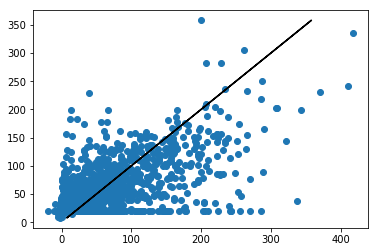

MAE: 31.8
RMSE: 47.4
R^2: 0.45


,fumble-2,fumble-1,fanPts-1,fumble-3,fanPts-2,yards_gained-1,yards_gained-2,rec_yards-2,air_yards-1,no_huddle-2,interception-2,incomplete_pass-2,complete_pass-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,pass_touchdown-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,complete_pass-1,pass_attempt-2,rush_yards-3,qb_dropback-2,rec_yards-3,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,rush_attempt-2,qb_hit-2
1,-0.992,-0.738,0.222,-0.099,0.056,0.052,0.008,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000


In [8]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.5s finished
C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best parameters set found on development set:
{'alpha': 0.0001, 'normalize': True}


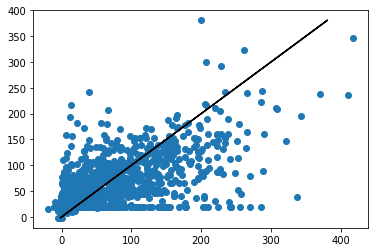

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-1,touchdown-2,touchdown-3,fanPts-1,fanPts-2,fanPts-3,complete_pass-3,complete_pass-1,complete_pass-2,rush_attempt-3,rush_attempt-1,yards_gained-2,rush_attempt-2,yards_gained-3,yards_gained-1
1,-4.722,-4.231,-2.352,0.974,0.734,0.333,-0.298,-0.235,-0.082,-0.063,-0.055,-0.047,-0.036,-0.010,-0.003


In [9]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

### Elastic Net Regression

#### Base model

C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


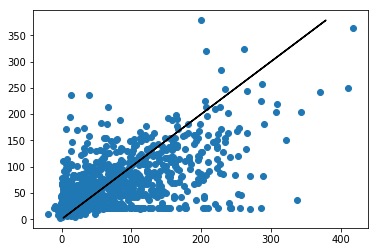

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,fumble-2,qb_dropback-1,incomplete_pass-1,tackled_for_loss-1,fumble-1,qb_hit-2,rush_attempt-1,qb_hit-1,qb_dropback-2,incomplete_pass-2,qb_dropback-3,fanPts-1,incomplete_pass-3,pass_attempt-1,rush_attempt-3,complete_pass-1,complete_pass-2,no_huddle-1,yards_gained-1,pass_touchdown-3,shotgun-3,shotgun-1,complete_pass-3,fanPts-2,rush_yards-1,yards_gained-3,yards_gained-2,rec_yards-1,fanPts-3,rush_yards-2,yards_after_catch-1,shotgun-2,rec_yards-2,no_huddle-3,tackled_for_loss-3,rush_yards-3,yards_after_catch-3,rush_attempt-2,yards_after_catch-2,air_yards-2,air_yards-3,air_yards-1,rec_yards-3,tackled_for_loss-2,pass_touchdown-1,pass_touchdown-2,pass_attempt-2,no_huddle-2,interception-1,interception-3,fumble-3,interception-2,rush_touchdown-2,touchdown-3,pass_attempt-3,rush_touchdown-1,rush_touchdown-3,touchdown-2,qb_hit-3,touchdown-1
1,-0.509,-0.460,0.436,0.357,-0.321,-0.298,-0.298,-0.242,-0.232,-0.224,-0.216,0.207,0.172,0.165,-0.133,0.121,0.095,-0.089,0.080,0.068,-0.047,0.041,-0.040,0.039,0.038,0.028,0.028,-0.019,-0.017,-0.014,-0.013,0.012,0.012,0.011,0.011,0.010,0.007,-0.007,0.006,0.006,-0.006,0.003,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000


In [10]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNet()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished


Best parameters set found on development set:
{'alpha': 10, 'normalize': False}


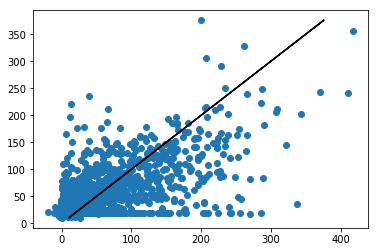

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,fanPts-1,rush_attempt-1,qb_dropback-3,qb_dropback-1,rush_attempt-3,yards_gained-1,rush_yards-1,rec_yards-2,incomplete_pass-1,shotgun-3,yards_gained-3,yards_gained-2,yards_after_catch-1,yards_after_catch-2,pass_attempt-1,fanPts-2,air_yards-3,rush_yards-2,air_yards-1,air_yards-2,yards_after_catch-3,rec_yards-1,touchdown-1,complete_pass-2,rush_touchdown-1,tackled_for_loss-1,shotgun-1,incomplete_pass-2,qb_hit-1,pass_touchdown-1,no_huddle-1,interception-1,fumble-1,complete_pass-1,fumble-2,rush_yards-3,interception-2,fumble-3,touchdown-3,tackled_for_loss-3,rush_touchdown-3,qb_hit-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,complete_pass-3,no_huddle-2,fanPts-3,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,rush_attempt-2,rec_yards-3,pass_touchdown-2,pass_attempt-2,qb_hit-2
1,-0.289,0.175,-0.172,-0.144,-0.090,-0.074,0.067,0.033,0.031,0.030,-0.025,0.021,0.019,-0.013,0.009,0.007,0.005,-0.004,-0.003,0.003,0.002,0.002,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000


In [11]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV

Alpha: 265.6479493448085
l1 ratio: 0.75


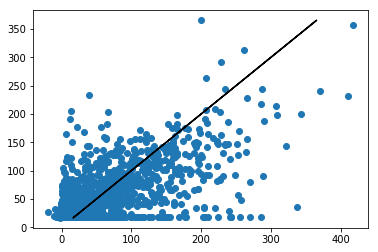

MAE: 31.8
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,rec_yards-2,air_yards-1,rush_yards-3,pass_attempt-2,no_huddle-2,interception-2,incomplete_pass-2,fumble-2,complete_pass-2,fanPts-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,qb_dropback-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,fumble-1,complete_pass-1,pass_touchdown-2,qb_hit-2,rec_yards-3,rush_attempt-2,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,fumble-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,fanPts-1
1,0.082,0.013,0.004,0.001,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [12]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, Scaled

Alpha: 265.6479493448085
l1 ratio: 0.75


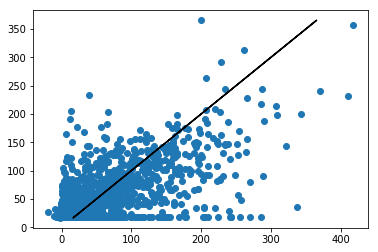

MAE: 31.8
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,rec_yards-2,air_yards-1,rush_yards-3,pass_attempt-2,no_huddle-2,interception-2,incomplete_pass-2,fumble-2,complete_pass-2,fanPts-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,qb_dropback-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,fumble-1,complete_pass-1,pass_touchdown-2,qb_hit-2,rec_yards-3,rush_attempt-2,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,fumble-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,fanPts-1
1,0.082,0.013,0.004,0.001,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [13]:
# X_train, X_dev, y_train, y_dev = X_train_scaled, X_dev_scaled, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, Standardized

Alpha: 265.6479493448085
l1 ratio: 0.75


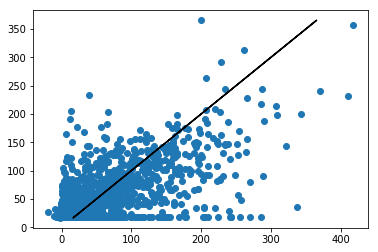

MAE: 31.8
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,rec_yards-2,air_yards-1,rush_yards-3,pass_attempt-2,no_huddle-2,interception-2,incomplete_pass-2,fumble-2,complete_pass-2,fanPts-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,qb_dropback-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,fumble-1,complete_pass-1,pass_touchdown-2,qb_hit-2,rec_yards-3,rush_attempt-2,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,fumble-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,fanPts-1
1,0.082,0.013,0.004,0.001,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [14]:
# X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.6s finished
C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best parameters set found on development set:
{'alpha': 0.0001, 'l1_ratio': 0.25, 'normalize': False}


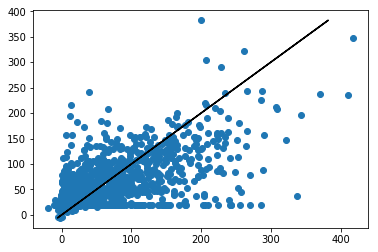

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-1,touchdown-2,touchdown-3,fanPts-1,fanPts-2,fanPts-3,complete_pass-3,complete_pass-1,complete_pass-2,yards_gained-2,rush_attempt-3,rush_attempt-1,rush_attempt-2,yards_gained-3,yards_gained-1
1,-5.314,-5.215,-3.249,1.072,0.901,0.484,-0.306,-0.244,-0.082,-0.064,-0.063,-0.056,-0.033,-0.024,-0.012


In [15]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features

Alpha: 174.7786119361002
l1 ratio: 0.75


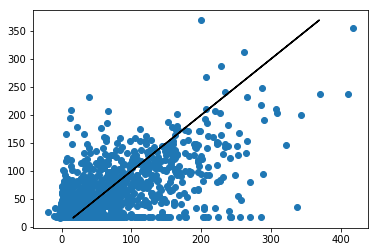

MAE: 31.9
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,fanPts-2,touchdown-1,rush_attempt-1,complete_pass-1,fanPts-1
1,0.083,0.016,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [16]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, scaled

Alpha: 174.7786119361002
l1 ratio: 0.75


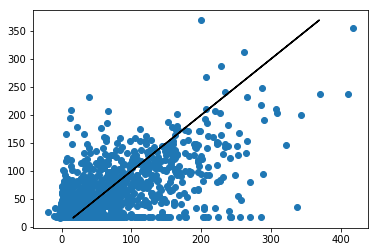

MAE: 31.9
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,fanPts-2,touchdown-1,rush_attempt-1,complete_pass-1,fanPts-1
1,0.083,0.016,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [17]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev ####

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, standardized

Alpha: 174.7786119361002
l1 ratio: 0.75


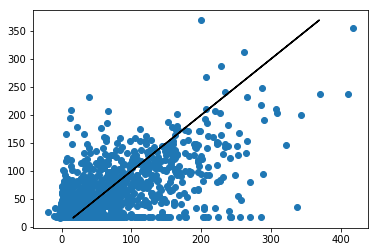

MAE: 31.9
RMSE: 47.5
R^2: 0.44


,yards_gained-1,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,fanPts-2,touchdown-1,rush_attempt-1,complete_pass-1,fanPts-1
1,0.083,0.016,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000


In [18]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev ####

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.1s finished


Best parameters set found on development set:
{'alpha': 10, 'l1_ratio': 0.75, 'normalize': False, 'positive': True}


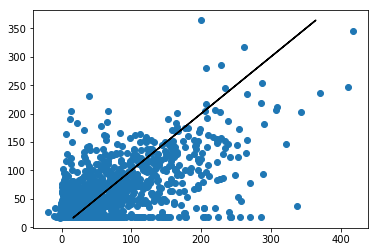

MAE: 31.8
RMSE: 47.5
R^2: 0.44


,fanPts-1,yards_gained-1,fanPts-2,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,touchdown-1,rush_attempt-1,complete_pass-1
1,0.193,0.057,0.025,0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [19]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75],
    'positive':[True]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, force positive coefficients

Alpha: 123.30285553509971
l1 ratio: 0.75


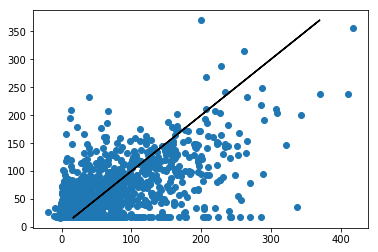

MAE: 31.8
RMSE: 47.6
R^2: 0.44


,yards_gained-1,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,fanPts-2,touchdown-1,rush_attempt-1,complete_pass-1,fanPts-1
1,0.083,0.016,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [20]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], positive=[True], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Bayesian Ridge Regression

#### Base model

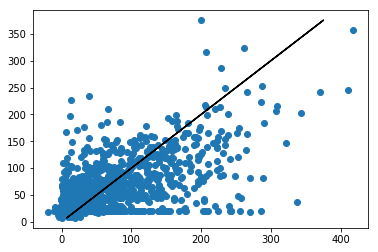

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,qb_dropback-1,rush_attempt-1,fanPts-1,qb_dropback-3,incomplete_pass-1,pass_attempt-1,rush_attempt-3,tackled_for_loss-1,fumble-1,fumble-2,incomplete_pass-2,incomplete_pass-3,qb_hit-2,no_huddle-1,complete_pass-2,yards_gained-1,qb_hit-1,shotgun-3,tackled_for_loss-2,fanPts-2,rush_yards-1,complete_pass-3,tackled_for_loss-3,fumble-3,rush_attempt-2,pass_touchdown-3,no_huddle-3,pass_attempt-3,pass_attempt-2,interception-1,shotgun-1,rec_yards-2,yards_gained-3,rush_touchdown-3,touchdown-2,yards_gained-2,touchdown-3,yards_after_catch-1,rush_yards-3,fanPts-3,interception-2,yards_after_catch-2,complete_pass-1,yards_after_catch-3,rec_yards-1,rec_yards-3,shotgun-2,pass_touchdown-1,rush_touchdown-2,air_yards-3,rush_touchdown-1,no_huddle-2,rush_yards-2,air_yards-2,air_yards-1,pass_touchdown-2,interception-3,qb_hit-3,touchdown-1
1,-0.253,-0.244,-0.214,0.185,-0.182,0.149,0.124,-0.120,0.101,-0.088,-0.083,-0.081,0.066,-0.066,-0.059,0.058,0.057,-0.056,-0.056,0.054,0.054,0.050,-0.049,0.047,-0.040,-0.029,0.028,0.027,0.026,-0.023,-0.022,0.021,0.021,0.019,-0.019,-0.019,0.019,-0.016,-0.015,0.014,-0.012,0.012,0.009,0.008,0.007,0.007,0.006,0.006,0.006,0.006,-0.005,0.005,-0.005,-0.004,0.003,0.003,-0.003,0.002,0.001,0.000


In [21]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.BayesianRidge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 453 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 693 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1605 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 2373 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2805 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3269 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3743 out of 3750 | elapsed:  1.6min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3750 out of 375

Best parameters set found on development set:
{'alpha_1': 0.01, 'alpha_2': 100, 'lambda_1': 100, 'lambda_2': 1, 'normalize': False}


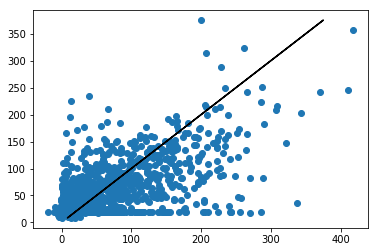

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,qb_dropback-1,rush_attempt-1,fanPts-1,qb_dropback-3,incomplete_pass-1,rush_attempt-3,pass_attempt-1,tackled_for_loss-1,fumble-1,incomplete_pass-2,fumble-2,yards_gained-1,shotgun-3,incomplete_pass-3,fanPts-2,no_huddle-1,qb_hit-2,rush_yards-1,tackled_for_loss-2,qb_hit-1,complete_pass-2,complete_pass-3,tackled_for_loss-3,fumble-3,rush_attempt-2,pass_attempt-2,no_huddle-3,rec_yards-2,pass_touchdown-3,yards_gained-2,yards_gained-3,shotgun-1,pass_attempt-3,interception-1,yards_after_catch-1,rush_touchdown-3,touchdown-2,touchdown-3,rush_yards-3,yards_after_catch-2,fanPts-3,rec_yards-1,interception-2,yards_after_catch-3,pass_touchdown-1,rec_yards-3,air_yards-3,rush_touchdown-1,touchdown-1,rush_yards-2,rush_touchdown-2,complete_pass-1,no_huddle-2,air_yards-2,air_yards-1,shotgun-2,pass_touchdown-2,interception-3,qb_hit-3
1,-0.236,-0.213,-0.198,0.176,-0.168,0.124,-0.112,0.103,0.080,-0.073,-0.071,-0.067,0.057,-0.054,0.053,0.052,-0.052,-0.051,0.048,0.047,-0.043,0.043,-0.042,0.039,-0.035,-0.029,-0.029,0.024,0.021,0.020,0.019,0.018,0.018,0.017,-0.016,-0.015,-0.015,-0.014,-0.013,0.013,0.010,-0.010,0.009,0.009,0.007,0.007,0.006,-0.005,0.005,0.004,-0.004,0.004,0.004,-0.003,0.003,0.003,0.002,-0.001,0.001,0.001


In [22]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1243 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1947 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2779 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:   26.7s finished


Best parameters set found on development set:
{'alpha_1': 1, 'alpha_2': 0.01, 'lambda_1': 0.1, 'lambda_2': 100, 'normalize': False}


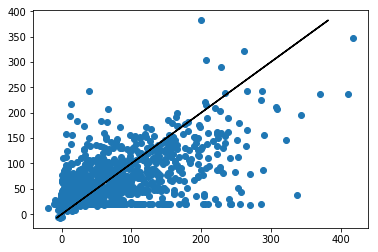

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-2,touchdown-1,touchdown-3,fanPts-1,fanPts-2,fanPts-3,complete_pass-3,complete_pass-1,yards_gained-2,complete_pass-2,rush_attempt-3,rush_attempt-1,rush_attempt-2,yards_gained-3,yards_gained-1
1,-5.773,-5.063,-3.237,1.035,1.003,0.485,-0.305,-0.245,-0.076,-0.064,-0.062,-0.057,-0.026,-0.025,-0.008


In [23]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

In [27]:
# X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

# params = {
#     'alpha_1':[10**x for x in range(-4,10)],
#     'alpha_2':[10**x for x in range(-4,10)],
#     'lambda_1':[10**x for x in range(-4,10)],
#     'lambda_2':[10**x for x in range(-4,10)],
#     'normalize':[True,False],
#     'positive':[True]
# }

# grid = GridSearchCV(
#     linear_model.BayesianRidge(),
#     params,
#     n_jobs = -1,
#     verbose = 7,
#     cv = 5
# )

# grid.fit(X_train,y_train)

# print("Best parameters set found on development set:")
# print(grid.best_params_)
     
# # cvGrid(params)

# clf = linear_model.BayesianRidge(**grid.best_params_)
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_dev)

# printStats(y_dev, y_pred)

# coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
# coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
# coefs